In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from os import path as op
import nibabel as nb
import numpy as np
from scipy.stats import zscore
from mriqc.interfaces.functional import auto_mask, find_spikes
from mriqc.interfaces.functional import Spikes
import matplotlib.pyplot as plt
from mriqc.interfaces.viz_utils import plot_mosaic

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [35]:
sub_id = '51205'
func_name = op.abspath('./example_artifacts_dataset/sub-ben01/func/sub-ben01_task-unknown_bold.nii.gz')
#func_name = op.abspath('./example_artifacts_dataset/sub-arielle01/func/sub-arielle01_task-unknown_bold.nii.gz')
#func_name = op.abspath('./example_artifacts_dataset/sub-ds001s07/func/sub-ds001s07_task-balloonanalogrisktask_run-03_bold.nii.gz')
func_name = op.abspath('./example_artifacts_dataset/sub-steph02/func/sub-steph02_task-unknown_bold.nii.gz')

#mask_name = op.abspath('./data/sub-ben01_task-unknown_bold_mask.nii.gz')
#func_name = './example_artifacts_dataset/sub-{0}/func/sub-{0}_task-rest_bold.nii.gz'.format(sub_id)
#mask_name = op.abspath('./data/sub-{}_task-rest_bold_mcf_mask.nii.gz'.format(sub_id))
ntsteps = nb.load(func_name).get_data().shape[-1]

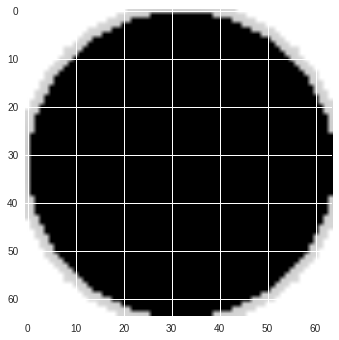

In [39]:
from scipy.ndimage.filters import median_filter
from scipy.ndimage.morphology import distance_transform_edt as distance
func_data = nb.load(func_name).get_data()

size = func_data.shape[:2]
ftmask = np.ones(size)

# Set zeros on corners
# ftmask[0, 0] = 0
# ftmask[size[0] - 1, size[1] - 1] = 0
# ftmask[0, size[1] - 1] = 0
# ftmask[size[0] - 1, 0] = 0
ftmask[size[0]/2, size[1]/2] = 0

# Distance transform
ftmask = distance(ftmask)
ftmask /= ftmask.max()

# Keep this just in case we want to switch to the opposite filter
ftmask *= -1.0
ftmask += 1.0

ftmask[ftmask > 0.3] = 1
ftmask[ftmask < 0.25] = 0
plt.imshow(ftmask)
#print(ftmask[0,0])


In [37]:
slices = []
spikes = []

fftvol = []
norm = func_data.shape[0] * func_data.shape[1]
for t in range(func_data.shape[-1]):
    func_frame = func_data[..., t]
    vals = []
    fftvol.append([])
    for sl in func_frame.T:
        fftsl = median_filter(np.absolute(np.fft.fft2(sl)), size=(5, 5), mode='constant')
        fftvol[-1].append(np.fft.fftshift(fftsl))
        energy = (fftsl ** 2 * ftmask)/norm
        vals.append(energy.sum())
    spikes.append(vals)

spikes = np.array(spikes)
spikes_zs = (spikes - np.median(spikes))/ spikes.std(ddof=1)
num_spikes = (spikes_zs>4.0).astype(int).sum(axis=1)

print(np.argwhere(num_spikes>0))
fftvol = np.array(fftvol).T


nii = nb.Nifti1Image(fftvol, nb.load(func_name).get_affine(), None)
nii.to_filename('fft.nii.gz')
# plot_mosaic(nii, fig=fig)

[[0]]


In [4]:
sp_if = Spikes(in_file=func_name, in_mask=mask_name, out_tsz='brain.txt')
res = sp_if.run()

sp_if2 = Spikes(in_file=func_name, automask='chris', out_tsz='chris.txt', no_zscore=False)
res2 = sp_if2.run()

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/nipy-0.4.0-py2.7-linux-x86_64.egg/nipy/labs/mask.py:235: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  delta = sorted_input[limiteinf + 1:limitesup + 1] \
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/nipy-0.4.0-py2.7-linux-x86_64.egg/nipy/labs/mask.py:236: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  - sorted_input[limiteinf:limitesup]
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/nipy-0.4.0-py2.7-linux-x86_64.egg/nipy/labs/mask.py:238: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  threshold = 0.5 * (sorted_input[ia + limiteinf]
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/nipy-0.4.0-py2.7-linux-x86_64.egg/nipy/labs/mask.py:2

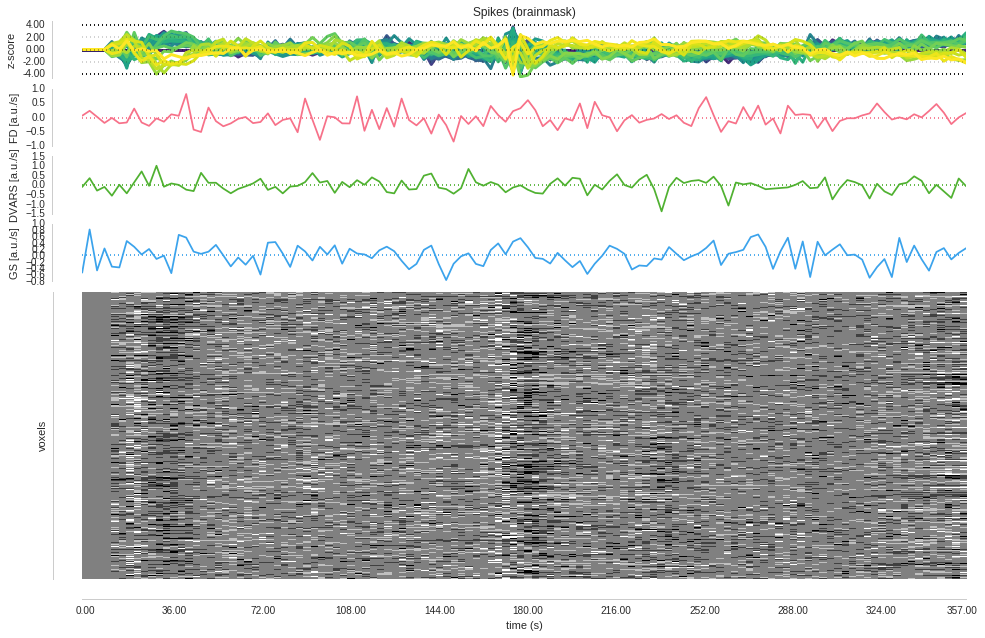

In [6]:
from mriqc.viz.fmriplots import fMRIPlot
myplot = fMRIPlot(func_name, mask_name)
myplot.add_spikes(np.loadtxt(res.outputs.out_tsz), 'Spikes (brainmask)')
#myplot.add_spikes(res2.outputs.out_tsz, 'Spikes (chrismask)')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'FD')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'DVARS')
myplot.add_confounds(np.random.normal(size=(ntsteps,)), 'GS')
myplot.plot()